# 1. Data Extraction
## 


In [329]:
# Import necessary modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [330]:
# Import timeseries sales data using Date column as index

df = pd.read_csv('../timeseries-forecasting/salesdata.csv', index_col='OrderDate', parse_dates=True)
df

,QtyOrdered
OrderDate,
2019-01-01,17828
2019-01-02,24361
2019-01-03,34678
2019-01-04,32561
2019-01-05,27595
...,...
2021-12-27,121599
2021-12-28,65161
2021-12-29,66323


In [331]:
# Explore dataset

df.describe()

,QtyOrdered
count,1096.000000
mean,57089.639599
std,26547.674989
min,11802.000000
25%,38937.000000
50%,52820.000000
75%,69706.000000
max,352569.000000


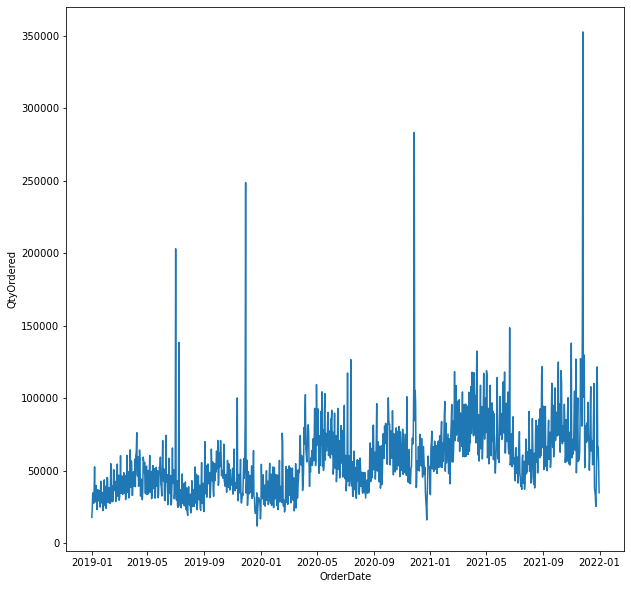

In [332]:
plt.figure(figsize=(10,10))
sns.lineplot(x=df.index, y=df.QtyOrdered);

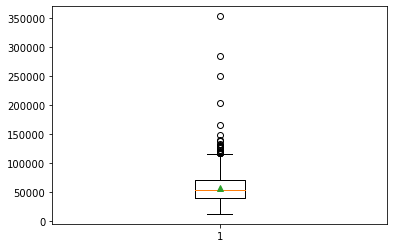

In [333]:
bp = plt.boxplot(x=df.QtyOrdered, showmeans=True);

In [334]:
# Show stats from boxplot using 'means' accessor that was enabled in showmeans=True parameter above

for key in bp:
    print(f'{key}: {[item.get_ydata() for item in bp[key]]}\n')

whiskers: [array([38937., 11802.]), array([ 69706., 114295.])]

caps: [array([11802, 11802], dtype=int64), array([114295, 114295], dtype=int64)]

boxes: [array([38937., 38937., 69706., 69706., 38937.])]

medians: [array([52820., 52820.])]

fliers: [array([203012, 138443, 248708, 117361, 126667, 283295, 118272, 117961,
       117590, 132452, 117166, 118945, 116239, 118053, 148577, 116136,
       121745, 124926, 119054, 137968, 126986, 127259, 164765, 352569,
       128251, 129750, 121599], dtype=int64)]

means: [array([57089.63959854])]



In [335]:
# Access the upper whisker value to set a threshold for outliers that need to be dealt with

upper_whisker_obj = bp['whiskers'][1]
upper_whisker = upper_whisker_obj.get_ydata()[1]

In [336]:
# Query rows that have values above upper whisker 

df_outliers = df.query(f"QtyOrdered >= {upper_whisker}")

In [337]:
# Fetch the mean values of the outliers that will serve as a threshold

df_threshold = df_outliers.describe().loc['mean'].values[0]

# 2. Data Cleaning
# 

In [338]:
# Convert outliers to NaN in order to replace them with a mean in given month

df[df['QtyOrdered'] >= df_threshold] = np.nan
outliers_idx = df[df['QtyOrdered'].isna()]

In [339]:
# Add month year for grouping

df['YearMonth'] = df.index.strftime('%Y') + '-' + df.index.strftime('%m')
df

,QtyOrdered,YearMonth
OrderDate,,
2019-01-01,17828.0,2019-01
2019-01-02,24361.0,2019-01
2019-01-03,34678.0,2019-01
2019-01-04,32561.0,2019-01
2019-01-05,27595.0,2019-01
...,...,...
2021-12-27,121599.0,2021-12
2021-12-28,65161.0,2021-12
2021-12-29,66323.0,2021-12


In [340]:
# Replace NaN values with the means in their respective months

df['QtyOrdered'] = df['QtyOrdered'].fillna(df.groupby('YearMonth')['QtyOrdered'].transform('mean'))
df.loc[outliers_idx.index]

,QtyOrdered,YearMonth
OrderDate,,
2019-07-01,34882.633333,2019-07
2019-11-29,44556.586207,2019-11
2020-11-27,66140.655172,2020-11
2021-06-21,76519.931034,2021-06
2021-11-25,83625.785714,2021-11
2021-11-26,83625.785714,2021-11


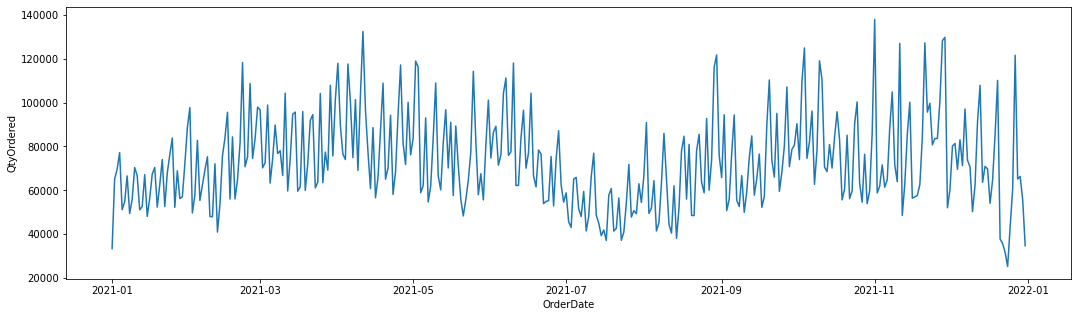

In [341]:
# Visualize result

plt.figure(figsize=(18,5))
sns.lineplot(data=df.loc['2021'], x=df.loc['2021'].index, y='QtyOrdered');

# 3. Data Exploration
# 

Text(0, 0.5, 'Seasonal')

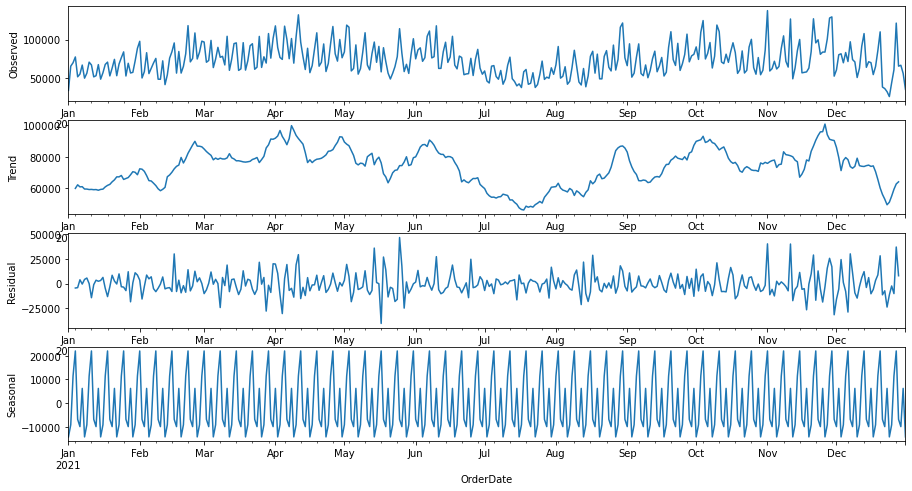

In [342]:
# Decompising time series into components

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df.loc['2021', 'QtyOrdered'], model='linear')

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(15,8))
result.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
result.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
result.resid.plot(ax=ax3)
ax3.set_ylabel('Residual')
result.seasonal.plot(ax=ax4)
ax4.set_ylabel('Seasonal')

In [343]:
# Testing with Augmented Dickey Fuller Test whether data is stationary in order to forecast the future -> requirement for ARIMA model

from statsmodels.tsa.stattools import adfuller, acf, pacf

adfuller_test = adfuller(df.loc['2020':'2021', 'QtyOrdered'], autolag='AIC') #autolag = Method to use when automatically determining the lag

adfuller_output = pd.Series(adfuller_test[:4], index=['Test Stats', 'p-value', '# of Lags', '# of obs'])
adfuller_output



Test Stats     -2.502628
p-value         0.114836
# of Lags      20.000000
# of obs      710.000000
dtype: float64

In [344]:
# p-value is >= 0.05 meaning that we have to accept null hypothesis that our time series is non-stationary. We have to make it stationary

df_2020_2021 = df.loc['2020':'2021', 'QtyOrdered'] # let's focus only on last two years
df_2020_2021 = df_2020_2021.to_frame() # format it into DataFrame

In [356]:
df_2020_2021['QtyOrdered_Diff'] = df_2020_2021['QtyOrdered'].diff() #using .diff() funtion to lag the data

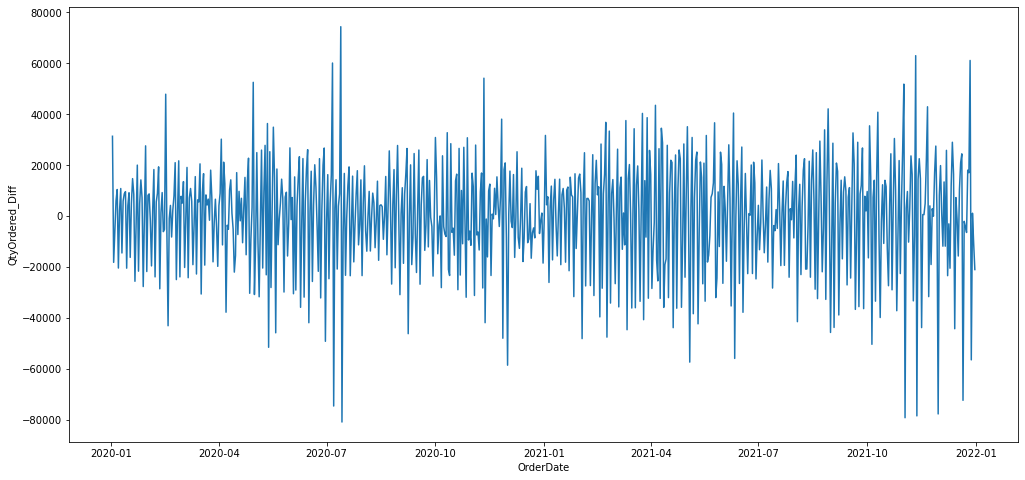

In [357]:
# We achieve the goal of data being stationary

plt.figure(figsize=(17,8))
sns.lineplot(data=df_2020_2021, x=df_2020_2021.index, y=df_2020_2021['QtyOrdered_Diff']);

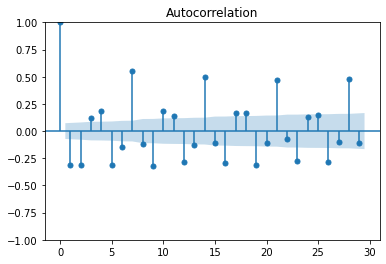

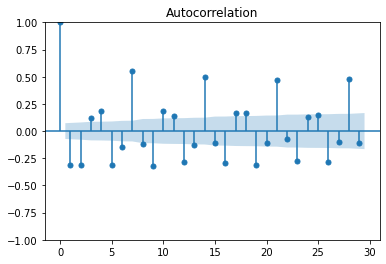

In [350]:
# Let's plot auto-correlation chart

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

plot_acf(df_2020_2021['QtyOrdered_Diff'].dropna())

In [ ]:
from pmdarima.arima import auto_arima